In [23]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns

In [209]:
# for first I will try to make generator learn this distribution
X= np.random.uniform(-2.0,2.0,1000)
Y = np.sqrt(4 - np.multiply(X, X))  + np.random.normal(0, 0.2, 1000)
X = X +  + np.random.normal(0, 0.2, 1000)

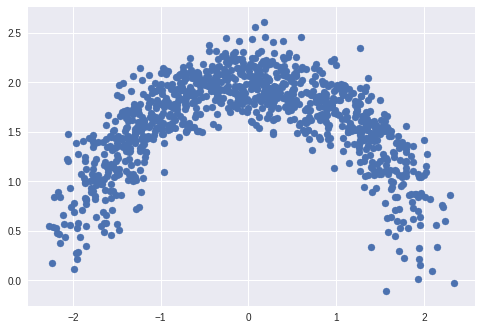

In [210]:
plt.scatter(X, Y)

In [225]:
my_data = np.column_stack((X, Y))

my generator for start

In [238]:
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh

generator_input = T.matrix('generator noise')
generator_layer = lasagne.layers.InputLayer((None, 2), generator_input)
generator_layer = lasagne.layers.DenseLayer(generator_layer, 50, nonlinearity=rectify)
generator_layer = lasagne.layers.DenseLayer(generator_layer, 20, nonlinearity=tanh)
generator_layer = lasagne.layers.DenseLayer(generator_layer, 10, nonlinearity=rectify)
generator_layer = lasagne.layers.DenseLayer(generator_layer, 2, nonlinearity=linear)
generator = generator_layer

generator_output = lasagne.layers.get_output(generator)

discriminator both for data from generator and for imput

In [239]:
# discriminators
D1_input = T.matrix('D1x')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 50, nonlinearity=rectify)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 10, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 1, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), generator_output)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 50, nonlinearity=rectify, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 10, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 1, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [240]:
# objectives
G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(generator, trainable=True)
G_updates = lasagne.updates.adadelta(1 - G_obj, G_params, learning_rate=1)
G_train = theano.function([generator_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_updates = lasagne.updates.adadelta(1 - D_obj, D_params, learning_rate=1)
D_train = theano.function([generator_input, D1_input], D_obj, updates=D_updates)

In [241]:
# functions for predicting 
get_fake = theano.function([generator_input], generator_output)
get_determine = theano.function([D1_input], D1_out)

In [242]:
# sample noise and phon for visualization
def sample_noise(M):
    return np.random.uniform(size = M)

def phon(M):
    return np.random.uniform(low = -3, high=3, size = M)

In [243]:
sample_noise(10), phon(10)

(array([ 0.48429578,  0.37116762,  0.2103733 ,  0.6966183 ,  0.94246356,
         0.45973423,  0.45986778,  0.97496012,  0.81347494,  0.13820718]),
 array([-0.26774604,  2.21936113, -1.31378253, -1.09129456,  0.09004573,
        -2.01377903,  0.54731394,  1.18049389, -0.32577045, -1.47115414]))

In [244]:
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [246]:
old_fake = []
noise_phon = phon(10000).reshape(5000, 2)
noise = sample_noise(1000).reshape(500, 2)
# training loop
epochs = 300
# number of time to trean discriminator and generator
k = 25
l = 1
# 
M = 1000

for i in range(epochs):
    for j in range(k):
        #if you want it to learn some normal distribution instead of my bublik         
        # x = np.float32(np.random.normal(0, 1, 2 * M))  
        x = np.float32(my_data)
        z = sample_noise(2*M)
        D_train(z.reshape(M, 2), x.reshape(M, 2))
    for j in range(l):    
        z = sample_noise(2*M)
        G_train(z.reshape(M, 2))

    #some plots     
    fake_money = get_fake(noise)
    prediction = get_determine(noise_phon)
    true_pred = np.column_stack((noise_phon, prediction))
    
    display.clear_output(wait=True)
    prediction = get_determine(noise_phon)
    true_pred = np.column_stack((noise_phon, prediction))
    
    if i != 0:
        fig = plt.figure(figsize=(17, 7))

        ax1 = fig.add_subplot(121)
        ax1.axis([-2.5,2.5,-0.5,3])
        sns.kdeplot(x.T[0], x.T[1], shade=True, shade_lowest=False, cmap='Greens')
        ax1.quiver(old_fake[:, 0], old_fake[:, 1],np.sign(fake_money[:, 0] -  old_fake[:, 0]),
                   np.sign(fake_money[:, 1] - old_fake[:, 1]), scale=5, scale_units='inches')
        
        ax2 = fig.add_subplot(122)
        ax2.scatter(true_pred[:, 0], true_pred[:, 1], c = (true_pred[:,2]), s=50, cmap='Greys')
        plt.show()
    old_fake = fake_money


KeyboardInterrupt: 

in the first image green is the distribution of original data, black vextors are generator output, in the second image the shade of the black shows the discriminator output for the grid(whiter means smaller)

lets see that generator output in the end is very similar to my original half bublik

create 3d histogram with real and generator distributions, blue in generator, green real data

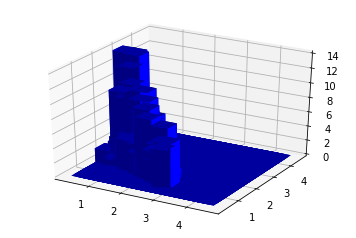

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = fake_money.T
x1, y1 = my_data.T
hist, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[0, 4], [0, 4]])
hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=30, range=[[0, 4], [0, 4]])

xpos, ypos = np.meshgrid(xedges1[:-1] + 0.25, yedges1[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

xpos1, ypos1 = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos1 = xpos1.flatten('F')
ypos1 = ypos1.flatten('F')
zpos1 = np.zeros_like(xpos1)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()
dz1 = hist1.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()

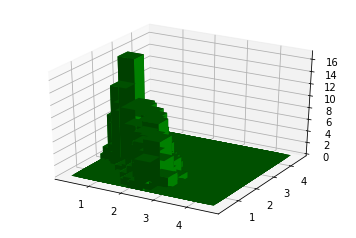

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos1, ypos1, zpos1, dx, dy, dz1, color='g', zsort='average')
plt.show()

as wee see in histogram, the distributions are very similar, so generaor not just creates data with similar position, also with similar distribution